<a href="https://colab.research.google.com/github/nathanchandanson/Majeure-STIC/blob/master/ML201/cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP deep learning

L'objectif de ce tp est de manipuler les algorithmes de deep learning.

Cependant, il faut bien voir que tuner un réseau est une tache complexe principalement à cause du temps nécessaire pour réaliser un apprentissage...

Aussi, l'axe choisi est d'insister sur la différence MLP vs CNN à travers des codes simples d'apprentissage.


## MLP

Tout d'abord, il existe seulement **2** grandes bibliothèques pour faire du CNN : pytorch (facebook) ou tensorflow (google)... Dans ce TP ce sera pytorch.

Techniquement la partie MLP aurait pu être traité avec scikit-learn mais ce sera fait...

donc déjà il faut importer pytorch

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

Ensuite on va charger les données.

**Normalement c'est genre 80% du temps de prendre en charge les données !**

Mais là on va travailler sur des données simples (MNIST) mises en forme par pytorch !

In [27]:
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])
mnisttrain = torchvision.datasets.MNIST("./mnist",train=True, transform=transform_mnist, download=True)
trainloader = torch.utils.data.DataLoader(mnisttrain, batch_size=64, shuffle=True, num_workers=2)
mnisttest = torchvision.datasets.MNIST("./mnist",train=False, transform=transform_mnist, download=True)
testloader = torch.utils.data.DataLoader(mnisttest, batch_size=64, shuffle=True, num_workers=2)

Commençons par visualiser quelques images

torch.Size([64, 1, 32, 32])


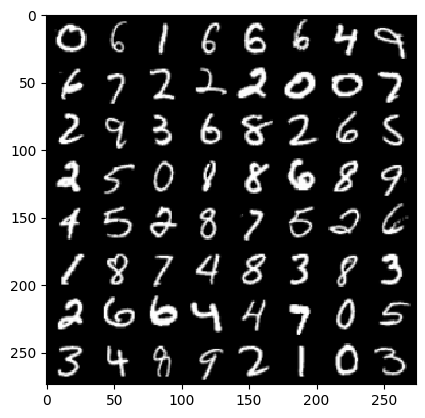

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample = next(iter(trainloader))[0]
show(torchvision.utils.make_grid(sample))
print(sample.shape)  ## 64 c'est le batch
                        ## 1 c'est du gris -- sinon ce serait 3 pour du RGB
                        ## 32x32 c'est pour la taille de l'image (petite ici)

maintenant on definit le réseau

In [5]:
class MonReseau(nn.Module):
    def __init__(self):
        super(MonReseau, self).__init__()

        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 2048)
        self.linear3 = nn.Linear(2048, 4096)

        self.final = nn.Linear(4096,10)

    def forward(self, x):
        x = x.view(-1,1024)  # l'image 1 x 32 x 32 devient un vecteur 1024
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))

        x = self.final(x)
        return x

monreseau = MonReseau()
monreseau = monreseau.cuda()

ensuite on définit les paramètres de l'apprentissage :
- le solver
- la loss
- le nombre d'itérations ...

In [6]:
optimizer = optim.Adam(monreseau.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
nbepoch = 5

l'apprentissage à proprement parler :
- on itere sur les données
- on les fait rentrer dans le réseau
- on compare la sortie courante à la sortie voulue
- on calcule le gradient
- on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue

**ET ON PASSE SUR CUDA CAR SINON C'EST TROP LONG**

In [7]:
import random
for epoch in range(nbepoch):
  monreseau.train()
  print("epoch", epoch)
  for inputs, targets in trainloader:   ## on itere sur les données
    inputs, targets = inputs.cuda(),targets.cuda()

    mespredictions = monreseau(inputs)  ## on les fait rentrer dans le réseau
    loss = criterion(mespredictions,targets)  ## on compare la sortie courante à la sortie voulue

    optimizer.zero_grad() ## supprime les gradients courants
    loss.backward() ## le gradient -- la magie par rapport à comment c'était long en court :-)
    optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue

    if random.randint(0,90)==0:
      print("\tloss=",loss) ## on affiche pour valider que ça diverge pas


epoch 0
	loss= tensor(2.2919, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(1.0736, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.8039, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.3657, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.6387, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.3779, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.2311, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.2959, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 1
	loss= tensor(0.3168, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.3023, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.3417, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.3920, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.1996, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.2826, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.2564, device='cuda:0', grad_fn

Maintenant, on calcule la performance obtenue **en test**
à travers la matrice de confusion
Mij c'est le nombre de fois qu'une image de la classe i a été classé comme j

In [8]:
from sklearn.metrics import confusion_matrix

monreseau.eval()
cm = np.zeros((10,10),dtype=int)  ###### ATTENTION DE BIEN ME REMETTRE A ZERO
with torch.no_grad():  ### ici pas besoin de calculer les gradients
    for inputs, targets in testloader:
        inputs = inputs.cuda()
        outputs = monreseau(inputs)
        _,pred = outputs.max(1)
        cm += confusion_matrix(pred.cpu().numpy(),targets.cpu().numpy(),labels =list(range(10)))
print(cm)

[[ 968    0    6    0    1    6   10    1    4    8]
 [   0 1111    1    1    0    1    3    8    1    6]
 [   1    3  976    8    6    0    2   24    4    2]
 [   1    2   11  968    0   16    1    5   20   12]
 [   0    1    9    0  955    5   11    8   10   46]
 [   3    1    1   10    0  843   12    1   14   10]
 [   4    4    5    0    5    9  917    0    9    1]
 [   2    2    7   10    2    1    0  960    6    9]
 [   1   11   15   12    3    7    2    2  903    5]
 [   0    0    1    1   10    4    0   19    3  910]]


**Q1 (facile)** : calculer le taux de bonne classification (donc la diagonale sur le total)

In [9]:
def accuracy(cm):
  return cm.trace()/cm.sum()
print(accuracy(cm))

0.9511


### CNN

**Q2 (dur)** : maintenant il faut changer le réseau pour mettre des convolutions et donc traiter la spécificité des images plutôt que de considérer ça comme un vecteur.

Dupliquer le code de "MonReseau" et implémenter lenet au lieu d'un simple mlp

regarder la doc : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

et regarder sur internet pour lenet vous aurez plein d'info !!

In [28]:
class MonReseauCNN(nn.Module):
    def __init__(self):
        # call the parent constructor
        super(MonReseauCNN, self).__init__()

        # initialize first set of CONV
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        # initialize second set of CONV
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # initialize third set of CONV
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Final layer
        self.final = nn.Linear(4096,10)

    def forward(self, x):
        # Pass the data through the first set of CONV => RELU => POOL layers
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Pass the data through the second set of CONV => RELU => POOL layers
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Pass the data through the second set of CONV => RELU
        x = F.leaky_relu(self.conv3(x))

        # Passe d'une représentation en plusieurs dimensions(ici 3) à une représentation en 1D
        x = x.view(-1,4096) # 64*8*8 devient 4096

        #
        x = self.final(x)
        return x

monreseauCNN = MonReseauCNN()
monreseauCNN = monreseauCNN.cuda()

Lancez maintenant un train/test

vous pouvez réutiliser quasiment tel quel la boucle "d'apprentissage" -- elle ne dépend PAS du réseau (les paramètres pourraient peut être changer mais dans les grosses lignes c'est la même boucle)

In [30]:
optimizer = optim.Adam(monreseauCNN.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
nbepoch = 5

# Apprentissage
import random
for epoch in range(nbepoch):
  monreseauCNN.train()
  print("epoch", epoch)
  for inputs, targets in trainloader:   ## on itere sur les données
    inputs, targets = inputs.cuda(),targets.cuda()

    mespredictions = monreseauCNN(inputs)  ## on les fait rentrer dans le réseau
    loss = criterion(mespredictions,targets)  ## on compare la sortie courante à la sortie voulue

    optimizer.zero_grad() ## supprime les gradients courants
    loss.backward() ## le gradient -- la magie par rapport à comment c'était long en court :-)
    optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue

    if random.randint(0,90)==0:
      print("\tloss=",loss) ## on affiche pour valider que ça diverge pas


# Evaluation réseau
from sklearn.metrics import confusion_matrix

monreseauCNN.eval()
cm = np.zeros((10,10),dtype=int)  ###### ATTENTION DE BIEN ME REMETTRE A ZERO
with torch.no_grad():  ### ici pas besoin de calculer les gradients
    for inputs, targets in testloader:
        inputs = inputs.cuda()
        outputs = monreseauCNN(inputs)
        _,pred = outputs.max(1)
        cm += confusion_matrix(pred.cpu().numpy(),targets.cpu().numpy(),labels =list(range(10)))
print(cm)
print(accuracy(cm))

epoch 0
	loss= tensor(2.2803, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(2.2786, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(2.2713, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(2.1779, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(1.6983, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(1.6245, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(1.5505, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(1.5359, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(1.1502, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.8006, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.7929, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.7813, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 1
	loss= tensor(0.5399, device='cuda:0', grad_fn=<NllLossBackward0>)
	loss= tensor(0.6940, device='cuda:0', grad_fn

# CNN VS MLP

Maintenant on va s'intéresser à la différence entre un mlp et un CNN


on fait regarder ce que donne nos codes -- si on permute les pixels
ce sera évidemment une permutation **FIXE** (ce sera la même pour toutes les images train et test) qu'on peut générer calculant une permutation des lignes et une des colonnes

In [ ]:
def computerandompermutation(n):
	out = list(range(n))
	random.shuffle(out)
	return out
permrow,permcol = computerandompermutation(32),computerandompermutation(32)
print(permrow)



**Q3 (moyenne) :** Coder une fonction qui prends en argument une permutation et une image et qui permute ses pixels.


*n'oubliez est pour permuter la valeur de x et y dans un tableau T il faut faire*
- tmp = T[y]
- T[y] = T[x]
- T[x] = tmp

(sinon on écrase une des 2 valeurs)

commencer par permuter une image 32x32 et créer une fonction qui l'applique 64 fois sur un batch 64x1x32x32

In [ ]:
print("TODO")

**SIGNALEZ que vous avez fini la question ci dessus -- il est nécessaire d'utiliser un codage efficace des permutations pour continuer -- il vous sera fourni**


**Q4 (facile) :**
Regarder les images avant et après permutation -- pourriez vous (vous même) classer les images APRES permutation ??


In [ ]:
print("TODO")

**Q5 (facile)** :
Qu'est ce que ça change pour le MLP ??
-> relancer l'apprentissage/test en ajoutant cette permutation pour valider que ça ne change rien !


In [ ]:
print("TODO")

**Q6 (facile)** : relancer le lenet -> là ça va changer

In [ ]:
print("TODO")


**Q7 (moyenne) :** faites une fonction qui ajoute du bruit (pour chaque pixel, mettez le à 0 ou à 1 avec une petite probabilité - le bruit est différent pour chaque image train et test)


In [ ]:
print("TODO")

**Q8 (facile)** : Regarder les images avant et après permutation -- pourriez vous (vous même) classer les images APRES permutation ??




In [ ]:
print("TODO")

**Q9 (facile)** : Tester le MLP et le CNN -> cette fois c'est le CNN qui devrait être "plutôt" invariant (le bruit est +/- filtré par la convolution) alors que le MLP devrait être gêné par le bruit !

In [ ]:
print("TODO")

## conclusion

**-> se souvenir que si on prend TOUS les problèmes, tous les algos de classification sont tous aussi mauvais**

**-> ce qui compte c'est qu'ils soient adaptés aux données qu'on peut réellement rencontrer**

**En comparant les images avec permutation des pixels vs avec un bruit... Vous pouvez comprendre pourquoi le CNN est plus adapté à l'image naturelle
que le MLP !**